<a href="https://colab.research.google.com/github/ali2066k/medical_imaging_tutorial/blob/main/Lungmask_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & Import Dependencies
First, we install the required packages (lungmask, monai, nibabel, matplotlib, etc.).

In [ ]:
# Install lungmask if not already installed
!pip install lungmask monai nibabel matplotlib numpy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2

# Load Dependencies

*   nibabel: Handles loading of NIfTI files.
*   monai.transforms: Prepares the CT scan for processing.
*   lungmask.mask: Generates the lung mask.
*   SimpleITK: Used for converting images to the format required by lungmask.


In [42]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImage, ScaleIntensityRange, Rotate90, EnsureChannelFirst
from lungmask import mask
import SimpleITK as sitk
import random
import matplotlib.pyplot as plt
from lungmask import LMInferer
import SimpleITK as sitk

# Load a CT Scan (NIfTI)

### Voxel Values (Hounsfield Units - HU)
CT scans are stored as **3D arrays**, where each voxel (3D pixel) has an intensity value representing the **Hounsfield Unit (HU)**.

- **Hounsfield Units (HU) Range**:
  - **Air**: ~ -1000 HU
  - **Lung Tissue**: ~ -700 to -500 HU
  - **Soft Tissue** (e.g., muscle): ~ 0 HU
  - **Bone**: ~ 300+ HU

🔹 Why is this important?
- Helps differentiate **air, lung tissue, soft tissue, and bone**.
- Essential for **segmentation, detection, and modeling**.
- Used for **diagnosing diseases** such as:
  - **Pneumonia** (increased lung density)
  - **Pulmonary edema** (fluid accumulation)
  - **Emphysema** (decreased lung density)
  - **Lung cancer** (abnormal tissue masses)
  - **COVID-19** (ground-glass opacities in lungs)
- Allows normalization to a fixed HU range (e.g., **[-1000, 400]**) for **consistent model input** in deep learning.

### Voxel Spacing (Resolution in mm)
Voxel spacing represents the **physical size** of each voxel in millimeters (mm). It is given as **(X, Y, Z) spacing**, where:
- X-axis: Width of a voxel (left-right)
- Y-axis: Height of a voxel (front-back)
- Z-axis: Slice thickness (depth)

🔹 Why is this important?
- Different CT scans can have different resolutions.
- Affects **image quality, shape, and model performance**.
- If spacing varies too much across patients, **resampling to a fixed spacing** is required to standardize input dimensions.

### CT Scan Orientation (RAS, LPS, etc.)
Medical imaging data is stored in different orientations depending on the scanner and hospital conventions.

🔹 Common Orientation Codes:
- **RAS (Right-Anterior-Superior)** → Standard convention in many imaging pipelines.
- **LPS (Left-Posterior-Superior)** → Used in some DICOM datasets.

🔹 Why is this important?
- Models trained on one orientation may **fail** if given data in a different orientation.
- We may need to **reorient the scan** to ensure consistency.
- Orientation is extracted using the **affine matrix** from `nibabel` or **direction cosines** from `SimpleITK`.

### Affine Matrix: Mapping Voxel Coordinates to Real-World Space
The affine matrix provides a **transformation** from voxel indices to real-world coordinates in millimeters.

🔹 How does it work?
- Defines the **position, orientation, and scale** of the scan.
- Ensures proper **alignment** when registering scans or overlaying segmentations.

More info: [https://nipy.org/nibabel/coordinate_systems.html](https://nipy.org/nibabel/coordinate_systems.html)

In [82]:
def load_nifti_image(file_path):
    """Load a NIfTI file using nibabel."""
    img = nib.load(file_path)
    data = img.get_fdata()
    return data, img.affine, img.header

ct_scan_path = "/content/ATM_064_0000.nii.gz"
ct_scan, affine, header = load_nifti_image(ct_scan_path)

print("CT Scan shape:", ct_scan.shape)

# Get voxel spacing
voxel_spacing = header.get_zooms()

# Get orientation (RAS, LPS, etc.)
orientation = nib.orientations.aff2axcodes(affine)

# Get scan shape (dimensions)
scan_shape = ct_scan.shape

print("CT Scan Metadata (NIfTI):")
print(f"Shape: {scan_shape}")
print(f"Voxel Spacing (mm): {voxel_spacing}")
print(f"Orientation: {orientation}")
print(f"Affine Matrix:\n{affine}")

# Print voxel value range
print(f"- Voxel Intensity Range: Min = {np.min(ct_scan)}, Max = {np.max(ct_scan)}")

CT Scan shape: (512, 512, 768)
CT Scan Metadata (NIfTI):
Shape: (512, 512, 768)
Voxel Spacing (mm): (0.8203125, 0.8203125, 0.5)
Orientation: ('L', 'P', 'S')
Affine Matrix:
[[ -0.8203125    0.           0.         223.02000427]
 [  0.          -0.8203125    0.          81.09999847]
 [  0.           0.           0.5        236.55000305]
 [  0.           0.           0.           1.        ]]
- Voxel Intensity Range: Min = -1024.0, Max = 3071.0


Visualize Random Slices of CT Scan

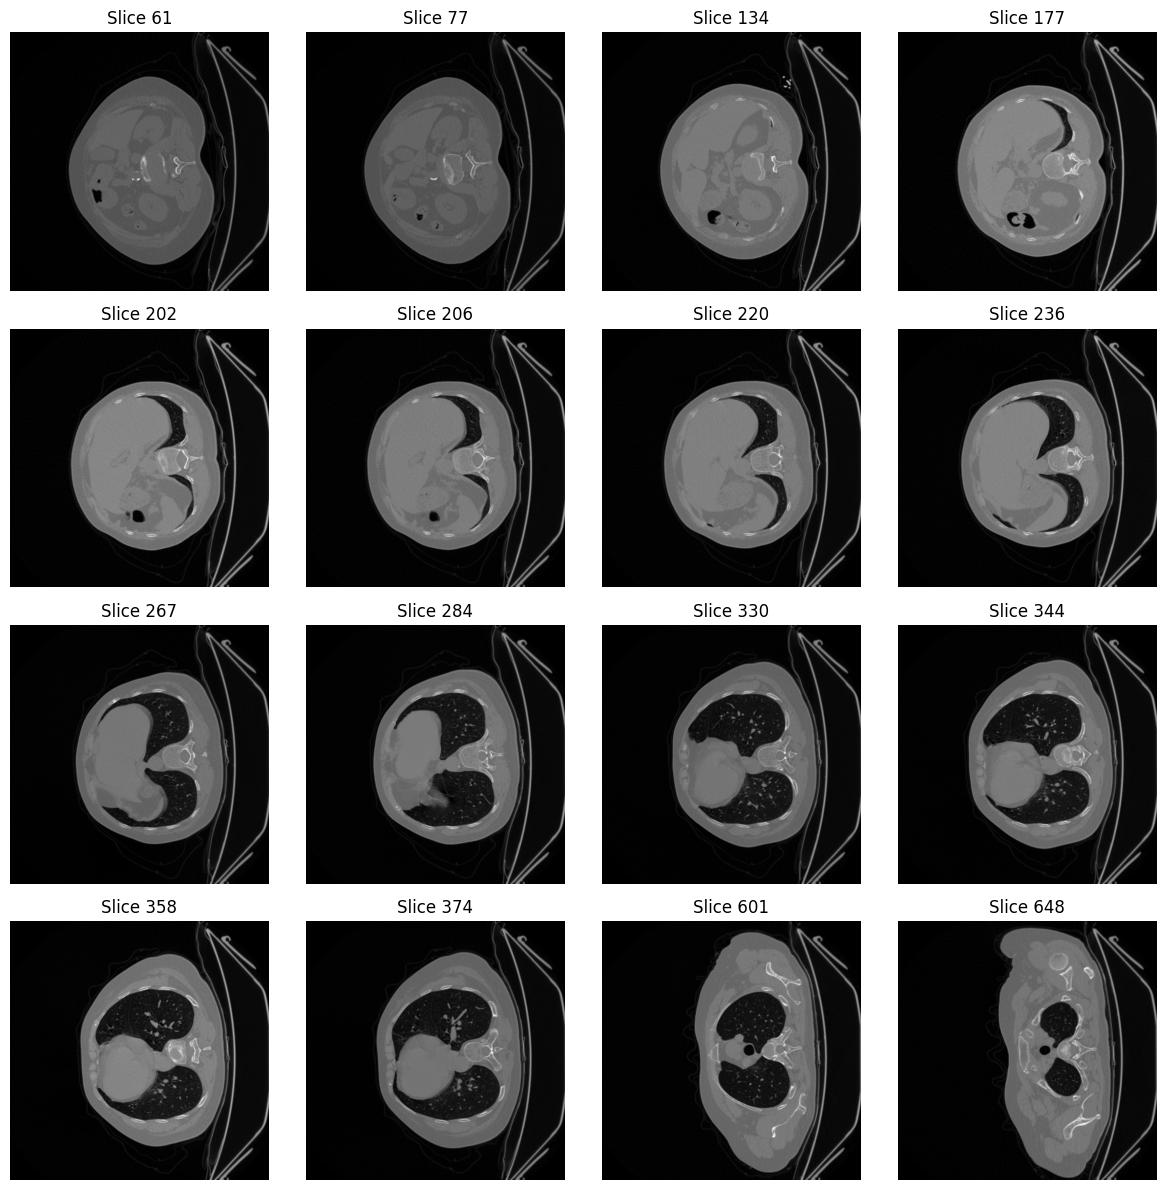

In [39]:
def plot_random_slices(ct_scan, num_slices=16, grid_size=(4, 4)):
    """Plot random slices from the CT scan in a grid."""
    slices = sorted(random.sample(range(ct_scan.shape[2]), num_slices))  # Select random slices
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        slice_idx = slices[i]
        ax.imshow(ct_scan[:, :, slice_idx], cmap="gray")
        ax.set_title(f"Slice {slice_idx}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize 16 random slices
plot_random_slices(ct_scan)

# Transform

### Preprocessing Adjustments Based on Metadata
Based on the extracted metadata, we may need to apply **preprocessing**:

🔹 **When to Resample Voxel Spacing?**
- If spacing varies too much between scans.
- Resample to a fixed spacing (e.g., **1mm × 1mm × 1mm**).

🔹 **When to Normalize Voxel Intensity?**
- If HU values are not consistent across scans.
- Normalize HU range to **[-1000, 400]** for lung segmentation.

🔹 **When to Reorient?**
- If the scan is not in a standard **RAS orientation**.
- Convert all scans to a common orientation for **consistency**.

# Define MONAI Transforms

In [44]:
# Define MONAI transforms
transforms = Compose([
    LoadImage(image_only=True),  # Load NIfTI
    EnsureChannelFirst(),  # Ensures data has channel dimension (C, H, W, D)
    ScaleIntensityRange(a_min=-1000, a_max=400, b_min=0, b_max=1, clip=True),  # Re-scale HU values
    Rotate90(k=3)  # Equivalent to np.rot90(ct_scan, k=3)
])

# Apply the transform
ct_scan_transformed = transforms(ct_scan_path)

print("Transformed CT shape:", ct_scan_transformed.shape)

Transformed CT shape: torch.Size([1, 512, 512, 768])


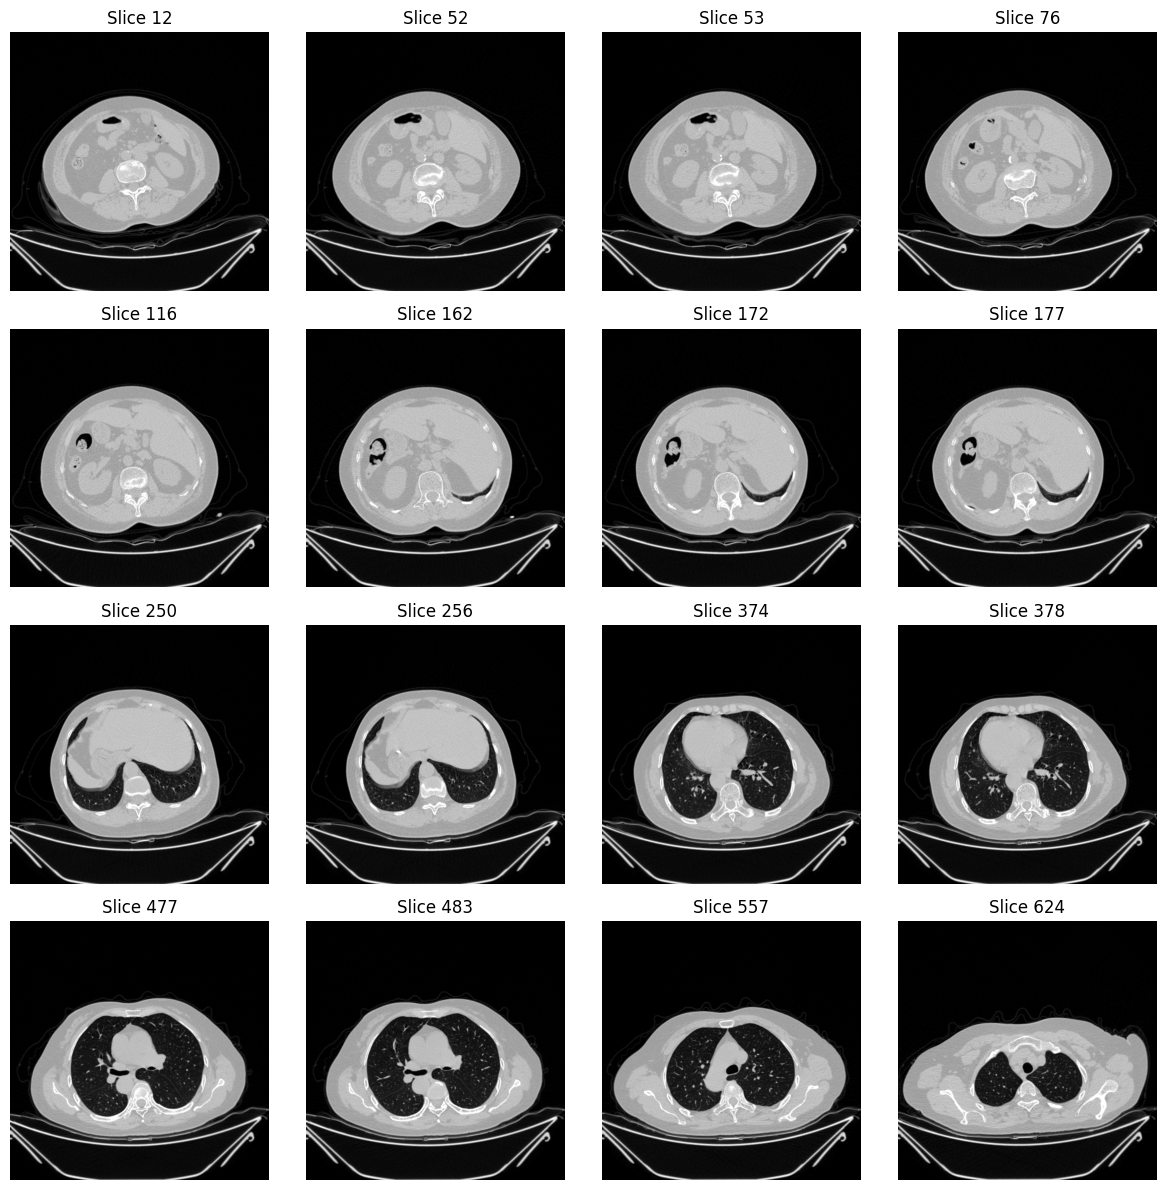

In [46]:
# Visualize 16 random slices
plot_random_slices(np.squeeze(ct_scan_transformed))

# Apply LungMask

### Why is this important?  
Lung segmentation is a **fundamental step** in many medical imaging tasks. It allows us to **isolate the lungs** from the surrounding anatomy, making further analysis more accurate. In this section, we apply **LungMask**, a pre-trained deep learning model, to automatically segment the lungs from a CT scan.

### **Why Do We Need Lung Segmentation?**
Lung segmentation is essential for a wide range of **clinical and research applications**, including:
- **Airway Segmentation** → Identifying and analyzing the bronchial tree for diseases like **COPD and asthma**.
- **Artery and Vessel Segmentation** → Extracting pulmonary arteries for detecting **pulmonary embolism (PE)**.
- **Lung Cancer Detection** → Enhancing tumor localization by removing irrelevant regions.
- **COVID-19 & Pneumonia Analysis** → Measuring infection spread via lung volume changes.
- **Lung Texture Analysis** → Quantifying lung density patterns for diseases like **fibrosis and emphysema**.

### **What Will We Learn?**
- How to apply **LungMask**, a state-of-the-art segmentation model.
- How to visualize the lung segmentation **overlayed on the CT scan**.
- How lung segmentation acts as a **preprocessing step** for advanced medical AI applications.

By learning lung segmentation, we **pave the way** for accurate disease detection, treatment planning, and deep learning applications in medical imaging.

In [104]:
# Initialize the inferer (default model: U-net R231)
inferer = LMInferer()

# Since the LungMask module works well with SimpleITK format, we use SimpleITK to load the CT scan
input_image = sitk.ReadImage(ct_scan_path)

# Apply lung segmentation
lung_mask = inferer.apply(input_image)  # Generates lung segmentation mask

print("Lung Mask shape:", lung_mask.shape)

# Apply post-processing to match the expected orientation
maskedLung = np.flip(np.rot90(np.rot90(lung_mask,k=3), axes=[1,2]),axis=2)
print("Post-processed Lung Mask shape:", maskedLung.shape)

39it [00:16,  2.34it/s]

lungmask 2025-01-30 23:42:43 Postprocessing



100%|██████████| 23/23 [00:02<00:00, 11.48it/s]


Lung Mask shape: (768, 512, 512)
Post-processed Lung Mask shape: (512, 512, 768)


Visualize the CT Scan and Lung Mask (Side by Side)

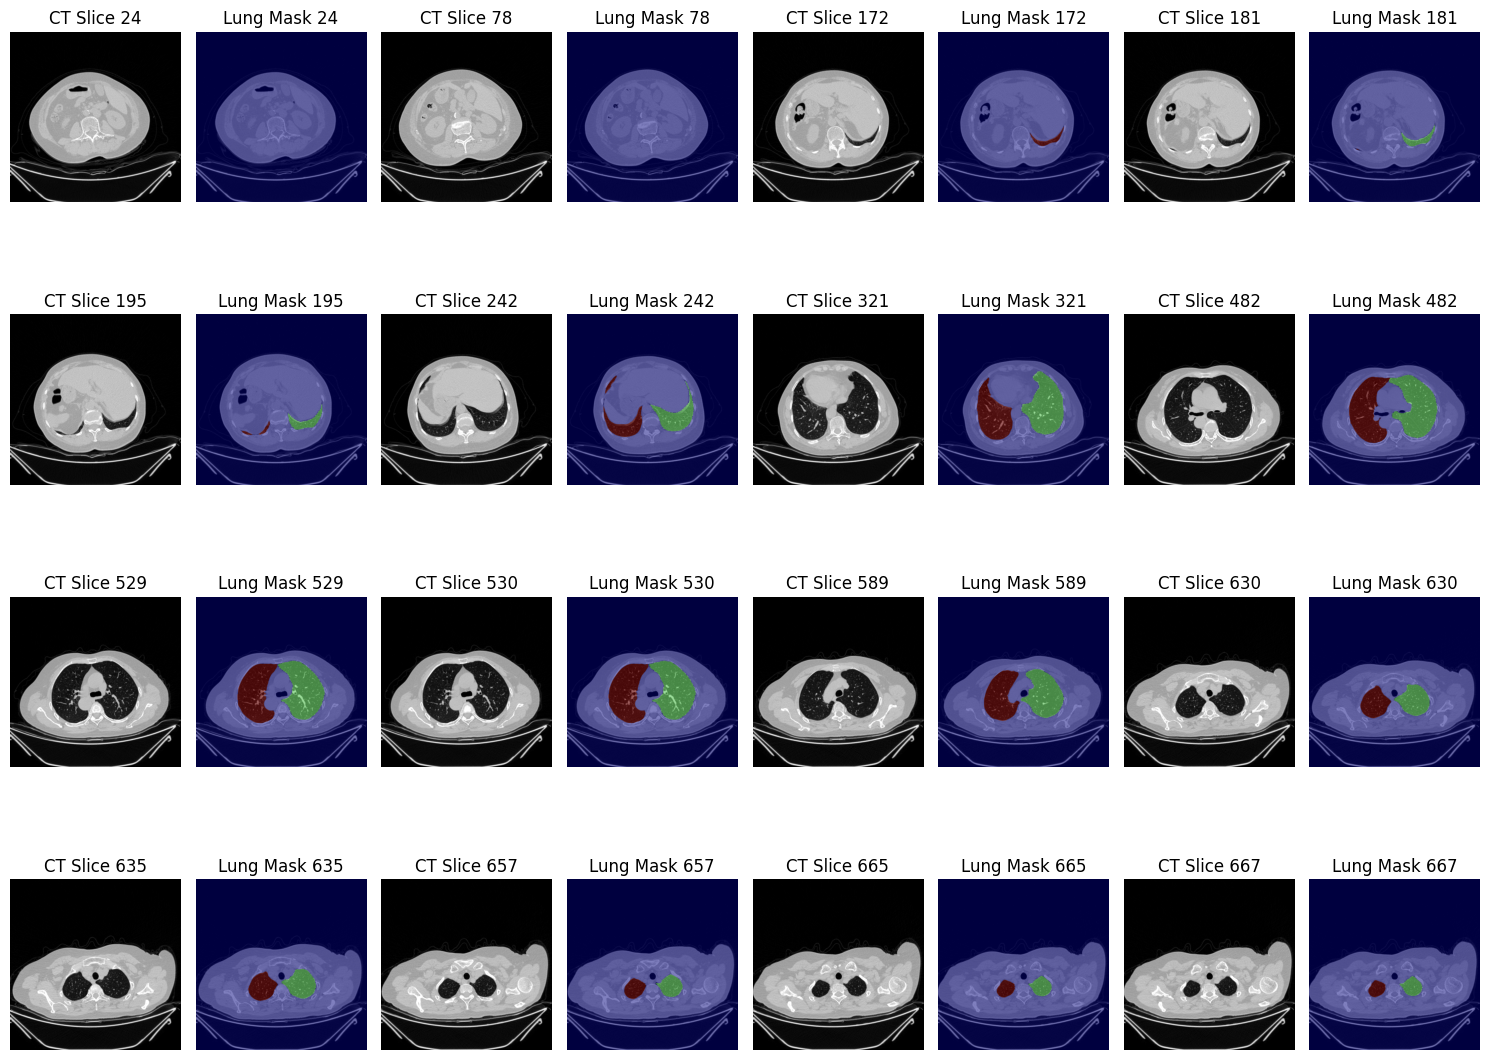

In [105]:
def plot_random_ct_slices_with_mask(ct_scan, lung_mask, num_slices=16, grid_size=(4, 4)):
    """Plot randomly selected CT slices alongside their corresponding lung masks."""
    slices = sorted(random.sample(range(ct_scan.shape[2]), num_slices))  # Select random slices

    fig, axes = plt.subplots(grid_size[0], grid_size[1] * 2, figsize=(15, 12))

    for i, slice_idx in enumerate(slices):
        row = i // grid_size[1]  # Row index
        col = (i % grid_size[1]) * 2  # Column index (each slice has 2 subplots)

        # CT scan slice
        axes[row, col].imshow(ct_scan[:, :, slice_idx], cmap="gray")
        axes[row, col].set_title(f"CT Slice {slice_idx}")
        axes[row, col].axis("off")

        # Lung mask overlay on CT scan
        axes[row, col + 1].imshow(ct_scan[:, :, slice_idx], cmap="gray")
        axes[row, col + 1].imshow(lung_mask[:, :, slice_idx], cmap="jet", alpha=0.5)  # Overlay lung mask
        axes[row, col + 1].set_title(f"Lung Mask {slice_idx}")
        axes[row, col + 1].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize 16 randomly selected slices with their lung masks
plot_random_ct_slices_with_mask(ct_scan_transformed.squeeze(), maskedLung)